# Rusty Bargain Car App

<div style="border: 2px solid black; padding: 15px; margin: 5px">

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

</div>

## Libraries & Packages

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from IPython.core.magic import register_cell_magic

from lightgbm import LGBMRegressor, early_stopping, log_evaluation

## Custom Time Magic

In [8]:
# Initiating dictionary to store processing times

timing_score = {}

@register_cell_magic
def savetiming(line, cell):
    """
    Usage:
    %%savetiming Step Name
    <code to run>
    """
    label = line.strip() or f"Step_{len(timing_score)+1}"

    start = time.time()
    get_ipython().run_cell(cell)
    elapsed = time.time() - start

    timing_score[label] = elapsed
    print(f"[{label}] took {elapsed:.2f} seconds")

## Data Preparation

In [12]:
# Importing dataset

data = pd.read_csv("car_data.csv")

In [14]:
# Viewing dataset info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [16]:
# Viewing dataset

data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [18]:
# Viewing columns

data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

<div style="border: 2px solid black; padding: 15px; margin: 5px">

After initial viewing of the dataset, we find "NaN" values, see that there are dates present and the columns needs a little formatting.

</div>

### Columns

In [23]:
# Renaming some of the columns


data.rename(
    columns={
               "DateCrawled": "date_crawled",
               "VehicleType": "vehicle_type",
               "RegistrationYear": "registration_year",
               "RegistrationMonth": "registration_month",
               "FuelType": "fuel_type",
               "NotRepaired": "not_repaired",
               "DateCreated": "date_created",
               "NumberOfPictures": "number_of_pictures",
               "PostalCode": "postal_code",
               "LastSeen": "last_seen",
    }, 
    inplace=True
)

# Columns formatting

data.columns = data.columns.str.strip()
data.columns = data.columns.str.lower()


In [25]:
# Column formatting validation

data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

<div style="border: 2px solid black; padding: 15px; margin: 5px">

Columns are formatted in the appropriate manner. Moving on to duplicates, missing values, and data type validation.

</div>

### Duplicates

In [30]:
# Checking for duplicates

duplicate_summary = pd.DataFrame({
    "duplicates_count": [data[col].duplicated().sum() for col in data.columns],
    "duplicates_percent": [data[col].duplicated().mean() * 100 for col in data.columns],
    "unique_values": [data[col].nunique() for col in data.columns],
    "total_rows": len(data)
}, index=data.columns)

duplicate_summary

,duplicates_count,duplicates_percent,unique_values,total_rows
date_crawled,338899,95.634494,15470,354369
price,350638,98.947143,3731,354369
vehicle_type,354360,99.997460,8,354369
registration_year,354218,99.957389,151,354369
gearbox,354366,99.999153,2,354369
power,353657,99.799079,712,354369
model,354118,99.929170,250,354369
mileage,354356,99.996332,13,354369
registration_month,354356,99.996332,13,354369
fuel_type,354361,99.997742,7,354369


<div style="border: 2px solid black; padding: 15px; margin: 5px">

There are many duplicates in each of the columns which makes sense considering the columns value inputs can be only a few choices for some of them. We will keep the duplicated values throughout and move onto missing values.

</div>

### Missing Values

In [35]:
# Viewing missing data summary

missing_summary = pd.DataFrame({
    "missing_count": data.isna().sum(),
    "missing_percent": (data.isna().mean() * 100).round(2),
    "unique_values": data.nunique(),
    "total_rows": len(data)
})

# Sorting values by missing count

missing_summary = missing_summary.sort_values(by="missing_count", ascending=False)

missing_summary


,missing_count,missing_percent,unique_values,total_rows
not_repaired,71154,20.08,2,354369
vehicle_type,37490,10.58,8,354369
fuel_type,32895,9.28,7,354369
gearbox,19833,5.60,2,354369
model,19705,5.56,250,354369
date_crawled,0,0.00,15470,354369
price,0,0.00,3731,354369
registration_year,0,0.00,151,354369
power,0,0.00,712,354369
mileage,0,0.00,13,354369


<div style="border: 2px solid black; padding: 15px; margin: 5px">

We're seeing a large amount of missing values, we need to see what's missing and decide why they could be missing and how to handle them.

</div>

In [38]:
# Viewing the values of each affected column

print("Not Repaired")
print(data["not_repaired"].value_counts(dropna=False))
print()

print("Vehicle Type")
print(data["vehicle_type"].value_counts(dropna=False))
print()

print("Fuel Type")
print(data["fuel_type"].value_counts(dropna=False))
print()

print("Gearbox")
print(data["gearbox"].value_counts(dropna=False))
print()

print("Model")
print(data["model"].value_counts(dropna=False))
print()


Not Repaired
not_repaired
no     247161
NaN     71154
yes     36054
Name: count, dtype: int64

Vehicle Type
vehicle_type
sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

Fuel Type
fuel_type
petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

Gearbox
gearbox
manual    268251
auto       66285
NaN        19833
Name: count, dtype: int64

Model
model
golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 251, dtype: int64



<div style="border: 2px solid black; padding: 15px; margin: 5px">

Here's our strategy for each of the columns:
- **"Not Repaired"** - We'll fill "unknown" for missing values
- **"Vehicle Type"** - We'll fill "other" for missing values
- **"Fuel Type"** - We'll fill "other" for missing values
- **"Gearbox"** - We'll fill "unknown" for missing values
- **"Model"** - We'll fill "unknown" for missing values

</div>

In [41]:
# Filling the not_repaired, gearbox and model columns with "unknown"

data["not_repaired"].fillna("unknown", inplace=True)
data["gearbox"].fillna("unknown", inplace=True)
data["model"].fillna("unknown", inplace=True)

# Filling the vehicle_type and fuel_type columns with "other"

data["vehicle_type"].fillna("other", inplace=True)
data["fuel_type"].fillna("other", inplace=True)

/var/folders/cp/t29hkt5j2055mnz846g13b000000gn/T/ipykernel_84656/3555125639.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["not_repaired"].fillna("unknown", inplace=True)
/var/folders/cp/t29hkt5j2055mnz846g13b000000gn/T/ipykernel_84656/3555125639.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [43]:
# Validating no more missing data

missing_summary2 = pd.DataFrame({
    "missing_count": data.isna().sum(),
    "missing_percent": (data.isna().mean() * 100).round(2),
    "unique_values": data.nunique(),
    "total_rows": len(data)
})

# Sorting values by missing count

missing_summary2 = missing_summary2.sort_values(by="missing_count", ascending=False)

missing_summary2


,missing_count,missing_percent,unique_values,total_rows
date_crawled,0,0.0,15470,354369
price,0,0.0,3731,354369
vehicle_type,0,0.0,8,354369
registration_year,0,0.0,151,354369
gearbox,0,0.0,3,354369
power,0,0.0,712,354369
model,0,0.0,251,354369
mileage,0,0.0,13,354369
registration_month,0,0.0,13,354369
fuel_type,0,0.0,7,354369


<div style="border: 2px solid black; padding: 15px; margin: 5px">

No more missing values present. Now, moving on to validating data types in the data.

</div>

### Data Types

In [48]:
# Viewing data types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

<div style="border: 2px solid black; padding: 15px; margin: 5px">

The **"registration_month"** and **"registration_year"** columns can be kept as int64 type.<br>

The **"date_crawled"**, **"date_created"**, **"last_seen"**, **"registration_month"**, **postal_code**, and **number_of_pictures** columns will be removed as they do not add value in predicting car price.<br>

No other data type needs to be adjusted in this set.

</div>

### Dropping Data

In [52]:
# We need to remove the following columns as they do not provide relevant information to predict car price

data = data.drop(["last_seen", "date_created", "registration_month", "postal_code", "number_of_pictures", "date_crawled"], axis=1)

# Validating removal of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       354369 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            354369 non-null  object
 4   power              354369 non-null  int64 
 5   model              354369 non-null  object
 6   mileage            354369 non-null  int64 
 7   fuel_type          354369 non-null  object
 8   brand              354369 non-null  object
 9   not_repaired       354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### Checking for Duplicates

In [55]:
# Checking for duplicates after dropping columns

duplicate_summary_3 = pd.DataFrame({
    "duplicates_count": [data[col].duplicated().sum() for col in data.columns],
    "duplicates_percent": [data[col].duplicated().mean() * 100 for col in data.columns],
    "unique_values": [data[col].nunique() for col in data.columns],
    "total_rows": len(data)
}, index=data.columns)

duplicate_summary_3

,duplicates_count,duplicates_percent,unique_values,total_rows
price,350638,98.947143,3731,354369
vehicle_type,354361,99.997742,8,354369
registration_year,354218,99.957389,151,354369
gearbox,354366,99.999153,3,354369
power,353657,99.799079,712,354369
model,354118,99.929170,251,354369
mileage,354356,99.996332,13,354369
fuel_type,354362,99.998025,7,354369
brand,354329,99.988712,40,354369
not_repaired,354366,99.999153,3,354369


### Outliers

In [58]:
# Using describe() to search for ourliers

data.describe().round()

,price,registration_year,power,mileage
count,354369.0,354369.0,354369.0,354369.0
mean,4417.0,2004.0,110.0,128211.0
std,4514.0,90.0,190.0,37905.0
min,0.0,1000.0,0.0,5000.0
25%,1050.0,1999.0,69.0,125000.0
50%,2700.0,2003.0,105.0,150000.0
75%,6400.0,2008.0,143.0,150000.0
max,20000.0,9999.0,20000.0,150000.0


<div style="border: 2px solid black; padding: 15px; margin: 5px">

After reviewing the means and medians in the data above, we can see that there are outliers that are skewing the mean. We need to find these outliers and remove them to help with accuracy in our training. <br><br>

Here's what we're seeing for each column:<br>

<b>price</b>
* Although the MAX value is a plausible one, we're seeing the minimum value as 0, which would mean no cost. <u>We will remove the rows with data of "0" in the `price` column.
<br>

<b>registration_year</b>
* The MAX value for this column is 9999 which isn't a valid year value. We will remove rows with this value in this column since we cannot determine the accurate year.
<br>

<b>power</b>
* This value is in "hp" (horsepower). We will choose "600" as the upper limit for this value. The MAX value here, 20,000, isn't a valid value for the unit it's describing.
<br>

<b>mileage</b>
* In the mileage column, there are a large majority of rows containing the mileage as "150,000" miles. We will remove these rows as they are skewing the data too widely.


</div>

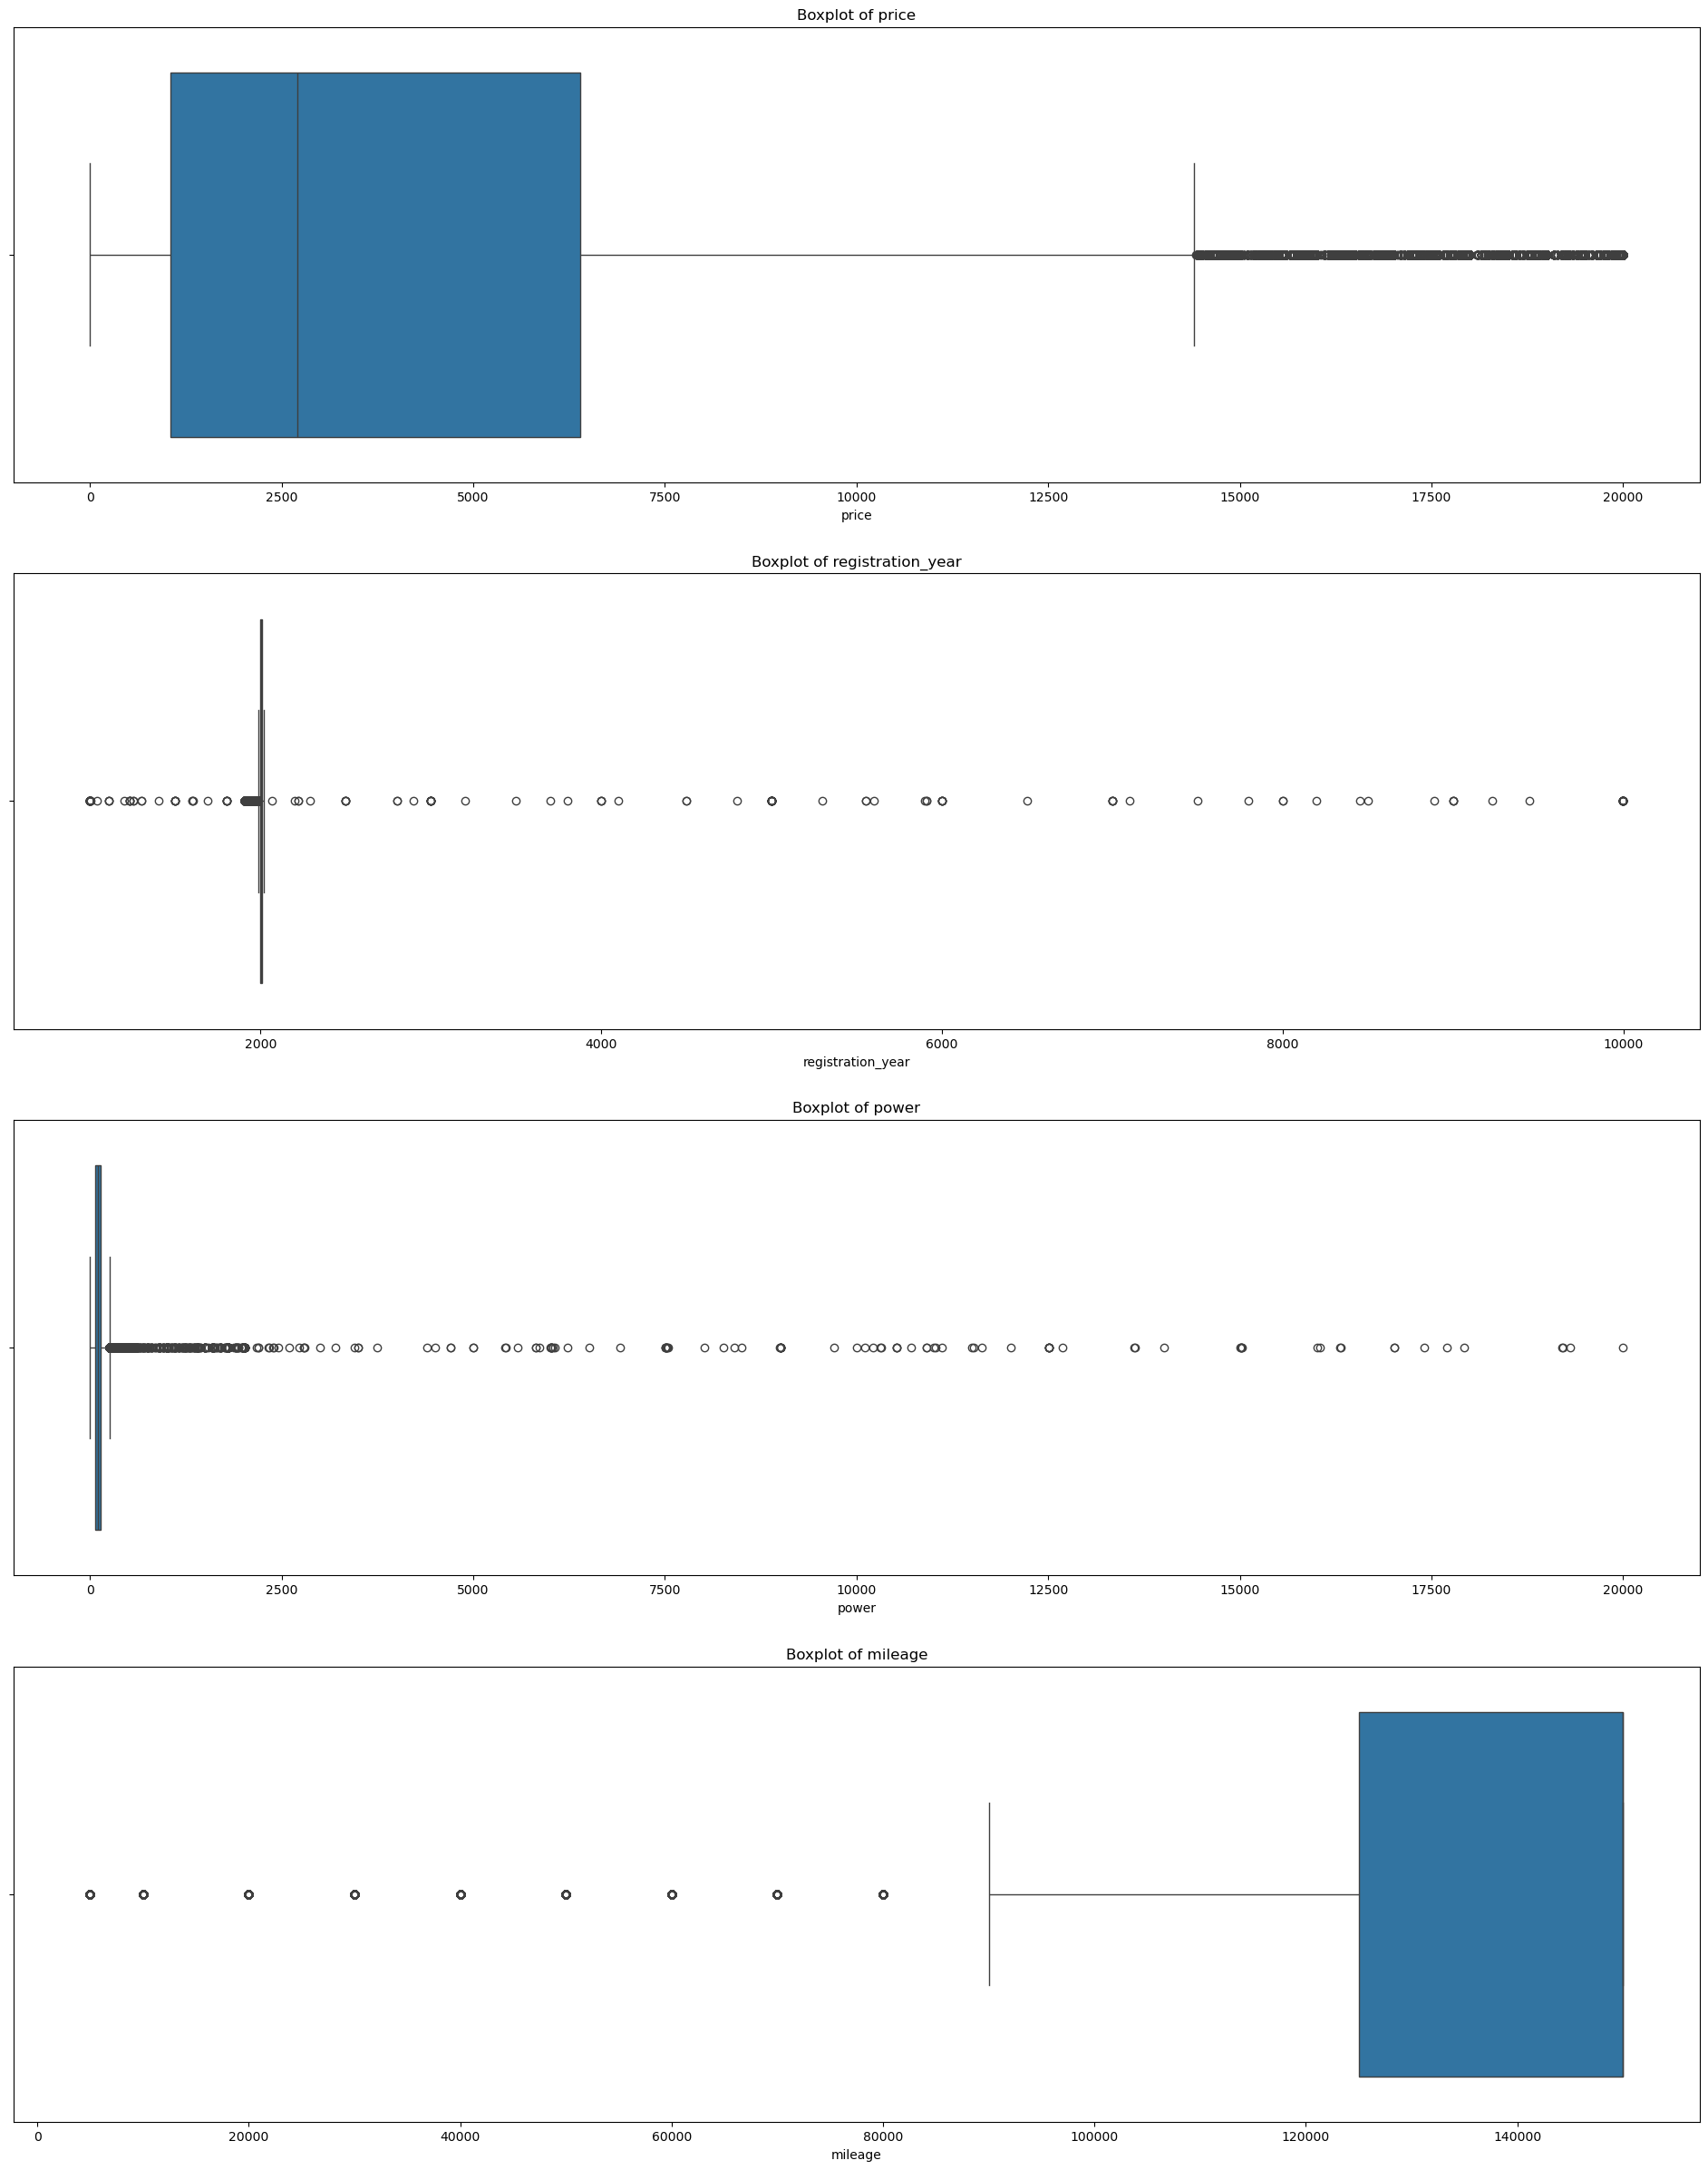

In [61]:
# Displaying the columns above with boxplots

cols = ["price", "registration_year", "power", "mileage"]

plt.figure(figsize=(24, 30))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 1, i)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")

plt.show()

#### `price` Column

In [64]:
# Displaying value_counts for `price` column

data['price'].value_counts()

price
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: count, Length: 3731, dtype: int64

In [66]:
# Removing rows with value 0, validating results

data = data[data['price'] != 0].reset_index(drop=True)

data['price'].value_counts()

price
500      5670
1500     5394
1000     4649
1200     4594
2500     4438
         ... 
7435        1
16845       1
17159       1
7396        1
10985       1
Name: count, Length: 3730, dtype: int64

#### `registration_year` Column

In [70]:
# Displaying values in this column

print(data['registration_year'].min(), data['registration_year'].max())

1000 9999


In [72]:
# Removing values that are greater than "2025", the current year.

data = data[(data["registration_year"] >= 1950) & (data["registration_year"] <= 2025)]

# Validating adjustments were made

print(data['registration_year'].min(), data['registration_year'].max())

1950 2019


#### `power` Column

In [76]:
# Displaying min and max values in this column

print(data['power'].min(), data['power'].max())

0 20000


In [78]:
# Removing values that are not within the lower and upper typical limits (75 - 600)

data = data[(data['power'] >= 75) & (data['power'] <= 600)]

# Validating that changes were made

print(data['power'].min(), data['power'].max())

75 600


#### `mileage` Column

In [82]:
# Displaying value counts in this column

data['mileage'].value_counts()

mileage
150000    173993
125000     25145
100000     10182
90000       8072
80000       7099
70000       6102
60000       5337
50000       4355
40000       3472
30000       3036
20000       2519
5000        2265
10000        676
Name: count, dtype: int64

In [84]:
# Removing the 173,993 rows that are skewing that data

data = data[data['mileage'] != 150000].reset_index(drop=True)

# Validating that changes were made

data['mileage'].value_counts()

mileage
125000    25145
100000    10182
90000      8072
80000      7099
70000      6102
60000      5337
50000      4355
40000      3472
30000      3036
20000      2519
5000       2265
10000       676
Name: count, dtype: int64

#### New Distributions

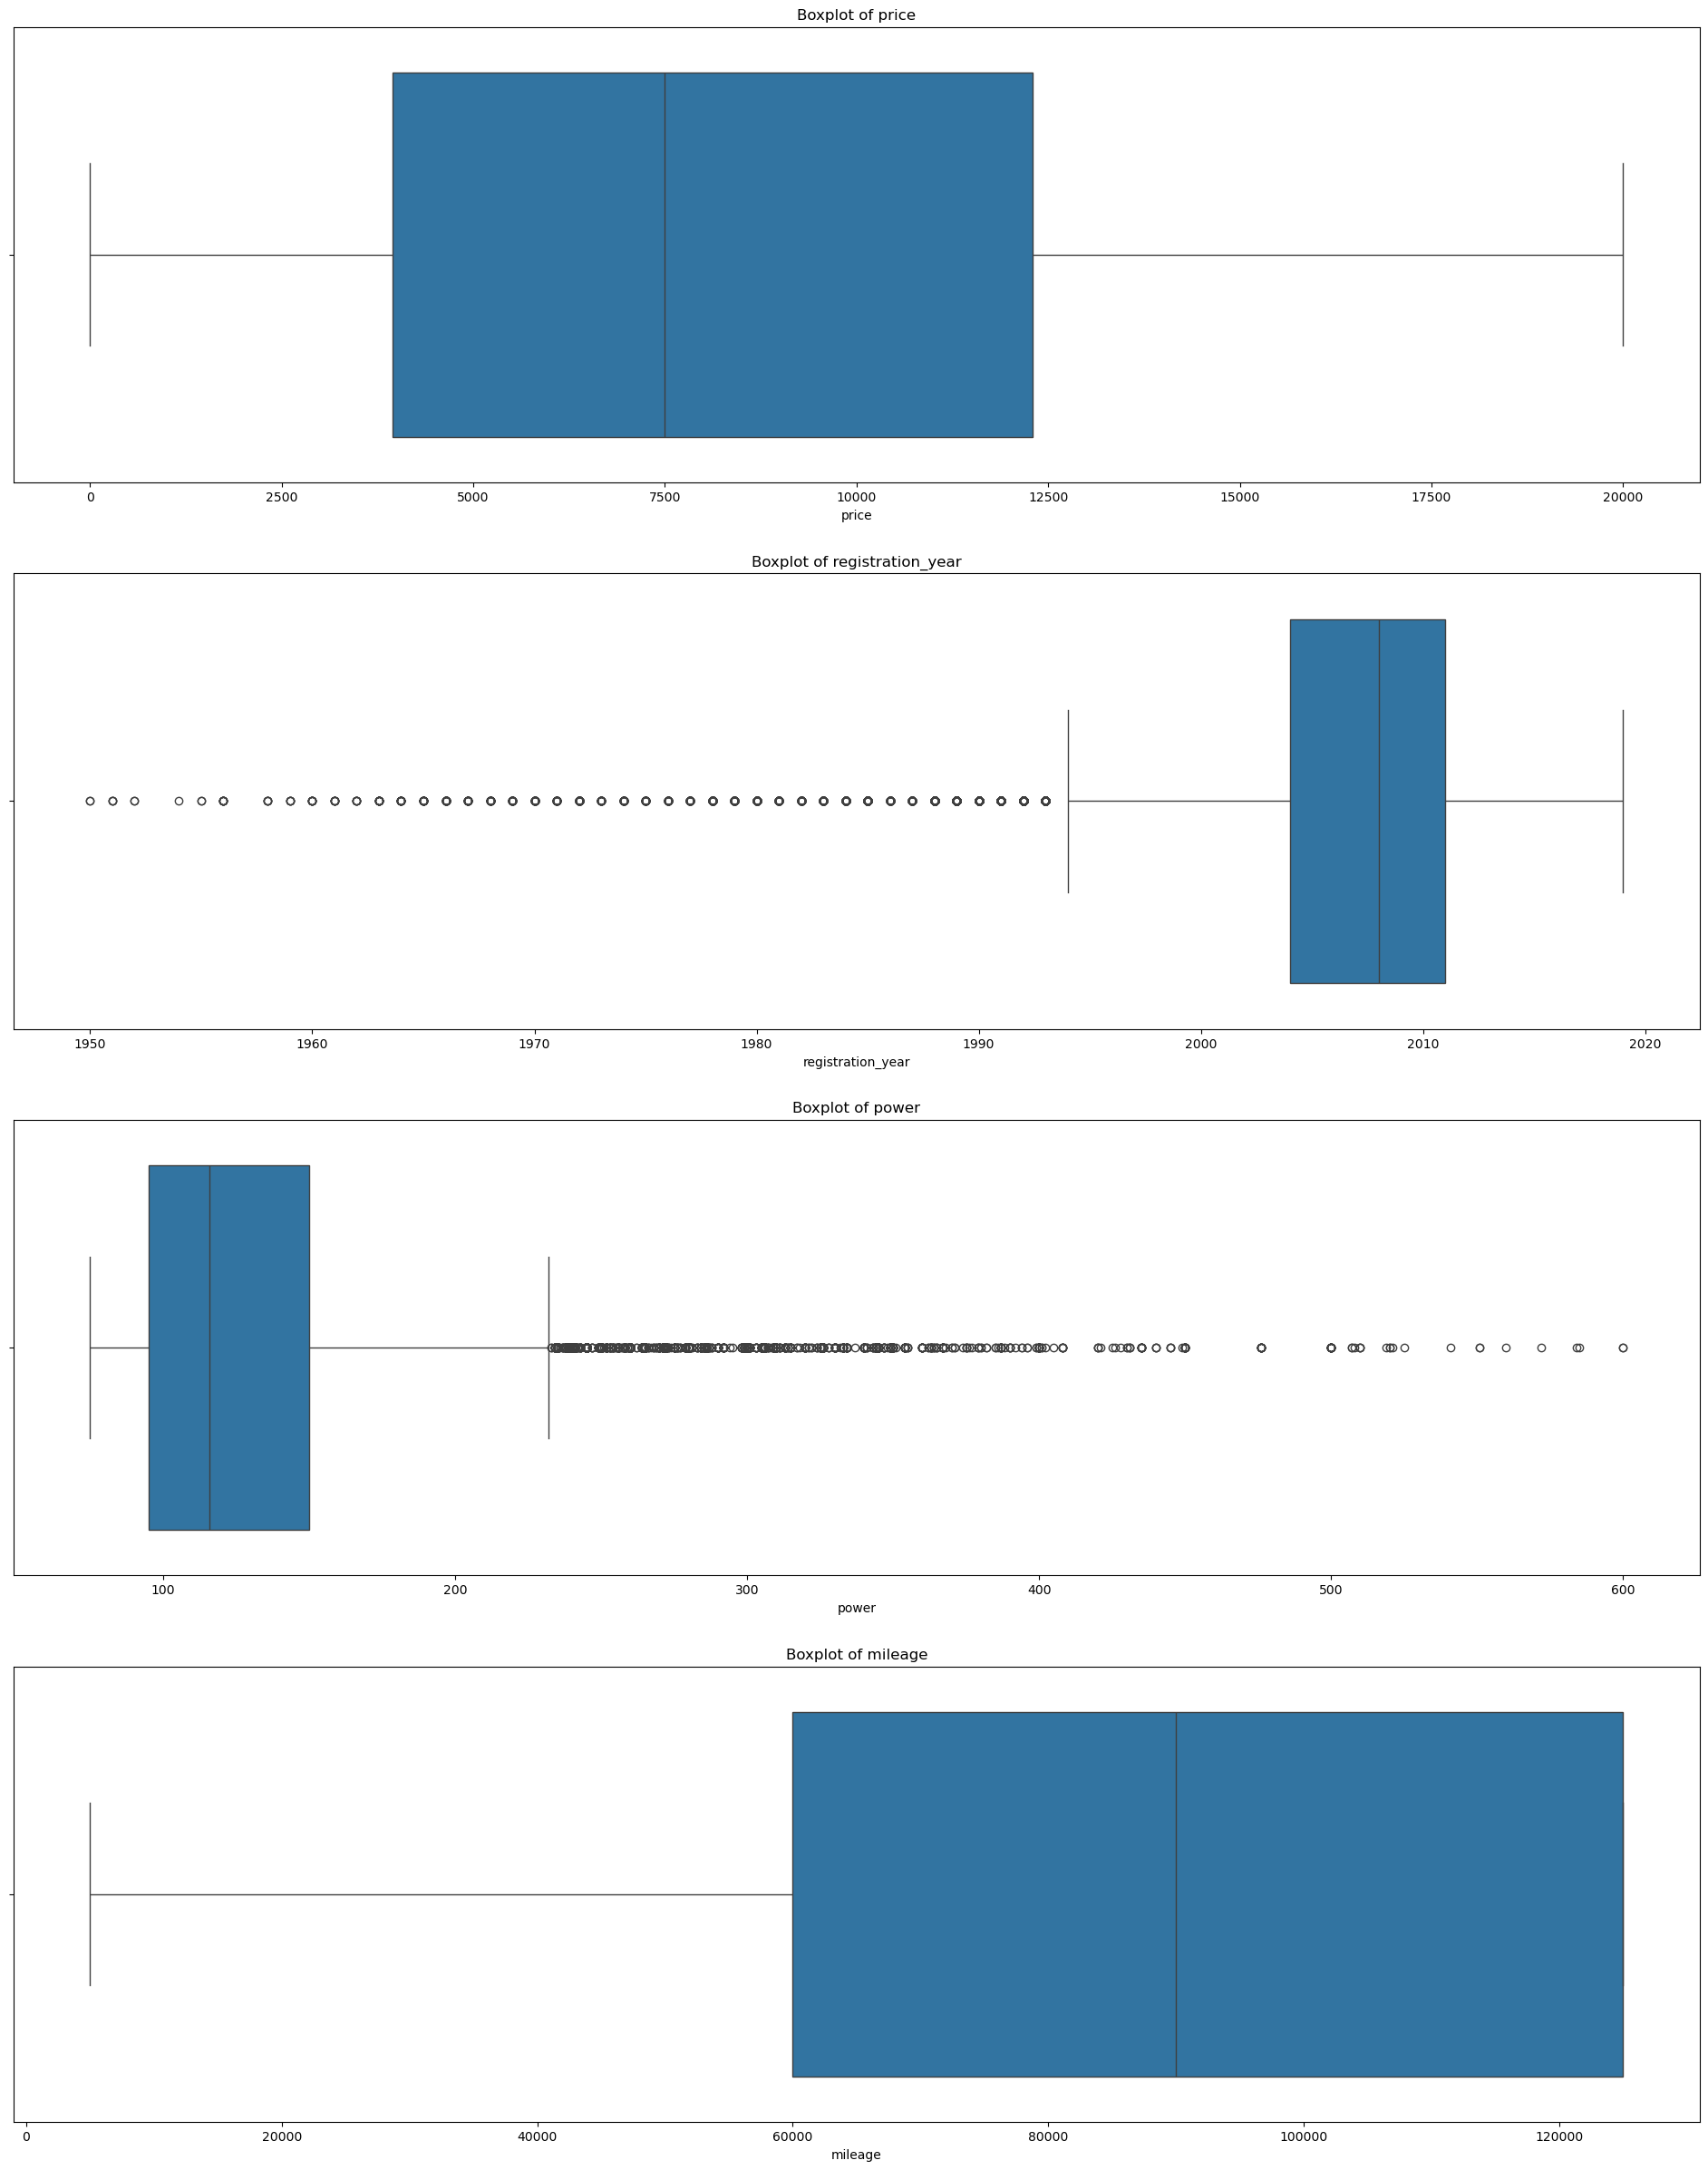

In [88]:
# Distributions after removing outliers

cols = ["price", "registration_year", "power", "mileage"]

plt.figure(figsize=(24, 30))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 1, i)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")

plt.show()

<div style="border: 2px solid black; padding: 15px; margin: 5px">

Although there is still outliers present in the columns, there is a much better distribution of data across all four data points.

</div>

## Model Training

### Linear Regression

In [94]:
%%savetiming Linear Regression Model

# Making a copy of the data set
data_lr = data.copy()

# Creating features and target
features_lr = data_lr.drop(['price'], axis=1)
target_lr = data_lr['price']

# Identifying categorical columns
cat_cols_lr = features_lr.select_dtypes(include=["object"]).columns

# OneHot Encoding for Categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_lr),
    ],
    remainder="passthrough"
)

# Splitting validation and training sets
features_train_lr, features_valid_lr, target_train_lr, target_valid_lr = train_test_split(
    features_lr, target_lr, test_size=0.3, random_state=12345
)

# Creating Pipeline = preprocessing + model
model_lr = make_pipeline(preprocessor, LinearRegression())

# Fitting & Predicting
start_time_lr_fit = time.time()
model_lr.fit(features_train_lr, target_train_lr)
end_time_lr_fit = time.time()

start_time_lr_predict = time.time()
predictions_valid_lr = model_lr.predict(features_train_lr)
end_time_lr_predict = time.time()

# Calculating run times
time_lr_fit = end_time_lr_fit - start_time_lr_fit
time_lr_predict = end_time_lr_predict - start_time_lr_predict

# Calculating RMSE on validation set
rmse_lr = np.sqrt(mean_squared_error(target_train_lr, predictions_valid_lr))
print(f"RMSE on Validation: {rmse_lr:,.2f}")
print()
print(f"LR Model Fit Time: {time_lr_fit:.2f} seconds")
print(f"LR Model Predict Time: {time_lr_predict:.2f} seconds")

RMSE on Validation: 3,100.33

LR Model Fit Time: 0.80 seconds
LR Model Predict Time: 0.09 seconds
[Linear Regression Model] took 0.91 seconds


In [96]:
# Comparing RMSE to the standard deviation of the target variable

# Creating variable for std of target
target_std_lr = np.std(target_lr, ddof=0)

print(f"Target Std: {target_std_lr:,.2f}")
print(f"LR Model RMSE: {rmse_lr:,.2f}")
print(f"% of Target Std: {rmse_lr / target_std_lr * 100:.2f}%")

Target Std: 5,269.73
LR Model RMSE: 3,100.33
% of Target Std: 58.83%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

When comparing the LR Model's RMSE to the Target Std, we're seeing that the model has reduced prediction error by about <b>41%</b> compared to simply predicting the average price for all listings. This means the model is capturing meaningful patterns, but there's still room to improve the model.

</div>

In [99]:
# Comparing RMSE of model to the baseline RMSE

# Calculating the mean of the target variable
baseline_pred_lr = np.full_like(target_valid_lr, fill_value=target_train_lr.mean(), dtype=np.float64)

# Displaying baseline RMSE
baseline_rmse_lr = np.sqrt(mean_squared_error(target_valid_lr, baseline_pred_lr))

# Comparing baseline to model RMSE
improvement_lr = (baseline_rmse_lr - rmse_lr) / baseline_rmse_lr * 100

print(f"Baseline RMSE: {baseline_rmse_lr:,.2f}")
print(f"Improvement Over Baseline: {improvement_lr:.2f}%")

Baseline RMSE: 5,281.93
Improvement Over Baseline: 41.30%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

Comparing to baseline, we're seeing that the LR model has improved it's prediction by a little bit more than 1/3rd compared to the baseline mean prediction. Improving the model through better feature engineering, additional data, or using a different model type will help to improve these numbers to close the gap even further.

</div>

### Random Forest

In [104]:
# Using RandomizedSearchCV to find best parameters for RF

# Initiating Pipeline
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(random_state=12345, n_jobs=-1))
])

# Parameters to test
param_dist = {
    "rf__n_estimators": [50, 75, 100],
    "rf__max_depth": [8, 10, 12],
    "rf__max_features": ["sqrt", 0.5],
    "rf__min_samples_split": [1, 2, 5],
    "rf__min_samples_leaf": [2, 5, 10],
    "rf__max_samples": [0.6, 0.8]
}

# Randomized search
random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=3,
    scoring="neg_root_mean_squared_error",
    cv=2,
    random_state=12345,
    verbose=1,
    n_jobs=-1
)

# Fitting with the training data
random_search.fit(features_train_lr, target_train_lr)

print("Best Params Found:", random_search.best_params_)
print()
print("Best CV RMSE:", -random_search.best_score_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best Params Found: {'rf__n_estimators': 50, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_samples': 0.6, 'rf__max_features': 0.5, 'rf__max_depth': 12}

Best CV RMSE: 2260.513490376324


In [107]:
%%savetiming Random Forest Model

# Using same variables from LR Model after OHE preprocessing

# Creating RF model
model_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=50,
        max_depth=12,
        random_state=12345,
        n_jobs=-1
    ))
])

# Fitting & Predicting
st_rf_fit = time.time()
model_rf.fit(features_train_lr, target_train_lr)
et_rf_fit = time.time()

st_rf_predict = time.time()
predictions_rf = model_rf.predict(features_train_lr)
et_rf_predict = time.time()

# Calculating run times
time_rf_fit = et_rf_fit - st_rf_fit
time_rf_predict = et_rf_predict - st_rf_predict

# Calculating RMSE for RandomForest
rmse_rf = np.sqrt(mean_squared_error(target_train_lr, predictions_rf))

print(f"RandomForest RMSE: {rmse_rf:,.2f}")
print()
print(f"LR Model Fit Time: {time_rf_fit:.2f} seconds")
print(f"LR Model Predict Time: {time_rf_predict:.2f} seconds")

RandomForest RMSE: 1,922.40

LR Model Fit Time: 5.46 seconds
LR Model Predict Time: 0.16 seconds
[Random Forest Model] took 5.63 seconds


In [109]:
# Comparing RMSE of RF to the STD of the target variable

# Creating variable for std of target
target_std_lr = np.std(target_lr, ddof=0)

print(f"Target Std: {target_std_lr:,.2f}")
print(f"LR Model RMSE: {rmse_rf:,.2f}")
print(f"% of Target Std: {rmse_rf / target_std_lr * 100:.2f}%")

Target Std: 5,269.73
LR Model RMSE: 1,922.40
% of Target Std: 36.48%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

When comparing the RF Model's RMSE to the Target Std, we're seeing that the model has reduced prediction error by over <b>63%</b> compared to simply predicting the average price for all listings. This means the model is performing well with still some room for parameter modifications.

</div>

In [112]:
# Comparing RMSE of RF model to the baseline RMSE

# Calculating the mean of the target variable
baseline_pred_rf = np.full_like(target_valid_lr, fill_value=target_train_lr.mean(), dtype=np.float64)

# Displaying baseline RMSE
baseline_rmse_rf = np.sqrt(mean_squared_error(target_valid_lr, baseline_pred_rf))

# Comparing baseline to model RMSE
improvement_rf = (baseline_rmse_rf - rmse_rf) / baseline_rmse_rf * 100

print(f"Baseline RMSE: {baseline_rmse_rf:,.2f}")
print(f"Improvement Over Baseline: {improvement_rf:.2f}%")

Baseline RMSE: 5,281.93
Improvement Over Baseline: 63.60%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

Comparing to baseline, we're seeing that the RF model has improved it's prediction by more than half compared to the baseline mean prediction. The RF model definitely performed better than the previous LR model.

</div>

In [115]:
# Comparing RMSE scores between LR and RF models

improvement_lr_rf = (rmse_lr - rmse_rf) / rmse_lr * 100

print(f"Improvement Over LR Model: {improvement_lr_rf:.2f}%")

Improvement Over LR Model: 37.99%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

The RF model produced almost 38% improvement in predictions to the target than the LR model. A very good sign and step up from LR.

</div>

### LightGBM

In [120]:
%%savetiming LightGBM Model

warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

# Preparing data and model

# Making copy of dataframe
data_lgb = data_lr.copy()

# Converting "object" type data to "category" type for the model
cat_cols = ["vehicle_type", "gearbox", "model", "fuel_type", "brand", "not_repaired"]

for col in cat_cols:
    data_lgb[col] = data_lgb[col].astype("category")

# Features & Target
features_lgb = data_lgb.drop(columns=["price"], axis=1)
target_lgb = data_lgb["price"]

# Splitting data
features_train_lgb, features_valid_lgb, target_train_lgb, target_valid_lgb = train_test_split(
    features_lgb, target_lgb, test_size=0.3, random_state=12345
)

# Initiating Model
lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=12345
)

# Fitting the model
st_lgb_fit = time.time()
lgbm.fit(
    features_train_lgb,
    target_train_lgb,
    eval_set=[(features_valid_lgb, target_valid_lgb)],
    eval_metric="rmse",
    categorical_feature=cat_cols,
    callbacks=[early_stopping(stopping_rounds=50),
              log_evaluation(period=50)]
)
et_lgb_fit = time.time()

# Predicting with the newly trained model
st_lgb_predict = time.time()
y_pred = lgbm.predict(features_train_lgb, num_iteration=lgbm.best_iteration_)
et_lgb_predict = time.time()

# Calculating RMSE
rmse_lgb = np.sqrt(mean_squared_error(target_train_lgb, y_pred))

# Calculating run times
time_lgb_fit = et_lgb_fit - st_lgb_fit
time_lgb_predict = et_lgb_predict - st_lgb_predict

print()
print(f"Best Iteration: {lgbm.best_iteration_}")
print(f"LightGBM RMSE: {rmse_lgb:,.2f}")
print()
print(f"LR Model Fit Time: {time_lgb_fit:.2f} seconds")
print(f"LR Model Predict Time: {time_lgb_predict:.2f} seconds")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 54782, number of used features: 9
[LightGBM] [Info] Start training from score 8324.913749
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 2705.7	valid_0's l2: 7.32082e+06
[100]	valid_0's rmse: 2230.71	valid_0's l2: 4.97607e+06
[150]	valid_0's rmse: 2111.98	valid_0's l2: 4.46047e+06
[200]	valid_0's rmse: 2062.74	valid_0's l2: 4.25491e+06
[250]	valid_0's rmse: 2041.05	valid_0's l2: 4.16587e+06
[300]	valid_0's rmse: 2025.62	valid_0's l2: 4.10314e+06
[350]	valid_0's rmse: 2014.56	valid_0's l2: 4.05844e+06
[400]	valid_0's rmse: 2004.75	valid_0's l2: 4.01902e+06
[450]	valid_0's rmse: 1995.87	valid_0's l2: 3.98348e+06
[500]	valid_0's rmse: 1988.38	

In [122]:
# Comparing RMSE of LightGBM to the STD of the target variable

print(f"Target Std: {target_std_lr:,.2f}")
print(f"LR Model RMSE: {rmse_lgb:,.2f}")
print(f"% of Target Std: {rmse_lgb / target_std_lr * 100:.2f}%")

Target Std: 5,269.73
LR Model RMSE: 1,528.99
% of Target Std: 29.01%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

When comparing the LightGBM Model's RMSE to the Target Std, we're seeing that the model has reduced prediction error by about <b>71%</b> compared to simply predicting the average price for all listings. This means the model is performing well with still some room for parameter modifications. Definitely the best score yet compared to the first two models.

</div>

In [125]:
# Comparing RMSE of LightGBM model to the baseline RMSE

# Comparing baseline to model RMSE
improvement_lgb = (baseline_rmse_rf - rmse_lgb) / baseline_rmse_rf * 100

print(f"Baseline RMSE: {baseline_rmse_rf:,.2f}")
print(f"Improvement Over Baseline: {improvement_lgb:.2f}%")

Baseline RMSE: 5,281.93
Improvement Over Baseline: 71.05%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

Comparing to baseline, we're seeing that the LightGBM model has improved even more than the RF model making it the most accurate in predicting the car prices thus far.

</div>

In [128]:
# Comparing RMSE scores between LR and RF models

improvement_rf_lgb = (rmse_rf - rmse_lgb) / rmse_rf * 100

print(f"Improvement Over RF Model: {improvement_rf_lgb:.2f}%")

Improvement Over RF Model: 20.46%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

Our LightGBM Model performed **20.46%** better at predicting car prices than our RF model.

</div>

## Model Analysis

<div style="border: 2px solid black; padding: 15px; margin: 5px">

After training all three models: LinearRegression, RandomForest and LightGBM, we can see that the clear winner is LightGBM. It has the lowest RMSE, meaning it predcits car prices much closer to the actual values than the other models. Further validation for this result is the result from the LinearRegression model, the lowest, which suggests that the relationship between the features and target in this instance are nonlinear and better suited for ensemble methods. All the models performed better than the Baseline RMSE, meaning they all outperformed just guessing the mean price.

In terms of processing times, the LinearRegression model won the race! The RandomForest Model and the LightGBM Model had similar processing times, though, LightGBM performed slightly quicker and was more accurate in the end. 

If speed was a priority, the LinearRegression model would be the first pick. But my recommendation for the Rusty Bargain Car App would be to use the LightGBM Model which was not the fastest, but definitely the most accurate. 

</div>

### Results

In [136]:
# Results Dataframe

data_results = {
    "Model": ["Baseline (Mean)", "Linear Regression", "Random Forest", "LightGBM"],
    "RMSE": [baseline_rmse_lr, rmse_lr, rmse_rf, rmse_lgb]
}

results_df = pd.DataFrame(data_results)

results_df

,Model,RMSE
0,Baseline (Mean),5281.934437
1,Linear Regression,3100.334905
2,Random Forest,1922.395969
3,LightGBM,1528.985889


### Timing Data

In [139]:
# Displaying the processing times

def show_timings():
    df = pd.DataFrame(list(timing_score.items()), columns=["Step", "Seconds"])
    df["Seconds"] = df["Seconds"].round(2)
    return df.sort_values("Seconds")

show_timings()

,Step,Seconds
0,Linear Regression Model,0.91
2,LightGBM Model,4.17
1,Random Forest Model,5.63


## Final Test on Best Model

In [143]:
%%savetiming LightGBM Model on Validation

# Using the LightGBM Model to predict on the validation set

# Predicting with the trained model
st_lgb_predict_final = time.time()
y_pred_final = lgbm.predict(features_valid_lgb, num_iteration=lgbm.best_iteration_)
et_lgb_predict_final = time.time()

# Calculating RMSE
rmse_lgb_final = np.sqrt(mean_squared_error(target_valid_lgb, y_pred_final))

# Calculating run time
time_lgb_final = et_lgb_predict_final - st_lgb_predict_final

print(f"LightGBM RMSE on Validation Set: {rmse_lgb_final:,.2f}")
print()
print(f"LightGBM Model Predict Time on Validation Set: {time_lgb_final:.2f} seconds")

LightGBM RMSE on Validation Set: 1,923.00

LightGBM Model Predict Time on Validation Set: 0.37 seconds
[LightGBM Model on Validation] took 0.37 seconds


In [145]:
# Comparing RMSE of LightGBM on Validation Set to the STD of the target variable

print(f"Target Std: {target_std_lr:,.2f}")
print(f"LightGBM Model RMSE: {rmse_lgb_final:,.2f}")
print(f"% of Target Std: {rmse_lgb_final / target_std_lr * 100:.2f}%")

Target Std: 5,269.73
LightGBM Model RMSE: 1,923.00
% of Target Std: 36.49%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

When comparing the LightGBM Model's RMSE on the **Validation Set** to the Target Std, we're seeing that the model has reduced prediction error by about <b>63%</b> compared to simply predicting the average price for all listings. 
<br>

Surprisingly, this is similar performance scoring compared to the LinearRegression model we did earlier in this study.
</div>

In [148]:
# Comparing RMSE of LightGBM model on Validation set to the baseline RMSE

# Comparing baseline to model RMSE
improvement_lgb_final = (baseline_rmse_rf - rmse_lgb_final) / baseline_rmse_rf * 100

print(f"Baseline RMSE: {baseline_rmse_rf:,.2f}")
print(f"Improvement Over Baseline: {improvement_lgb_final:.2f}%")

Baseline RMSE: 5,281.93
Improvement Over Baseline: 63.59%


<div style="border: 2px solid black; padding: 15px; margin: 5px">

Comparing to baseline, we're seeing that the LightGBM model has an RMSE scoring predicting over **63%** accuracy over the baseline RMSE. 
<br>

This result is similar to the comparison we made with the RandomForest earlier in this project. 

</div>

## Overall Conclusion

<div style="border: 2px solid black; padding: 15px; margin: 5px">

<b><u>Data Preprocessing</u></b><br>
&nbsp;&nbsp; In the scope of this project, we performed data preprocessing which included validating column format, searching for duplicates and handling them appropriately based on type of data and value added to model training, searched for missing values, checked data types, dropped unnecessary columns not suitable for model training and finally checked for duplicates once more after dropping columns.
<br>

<b><u>Outliers</u></b><br>
&nbsp;&nbsp; After preprocessing, we searched for outliers and found that the spread of data was too large for certain columns. We removed outliers and validated that the range of data was within reasonable limits taking into account their representation of the cars involved to ensure accuracy in final predictions of the model. We also displayed distributions with boxplots before, and after, dealing with outliers in the data to visually represent the difference in the spread of the data.
<br>

<b><u>Model Training</u></b><br>
&nbsp;&nbsp; Next, we trained three models: LinearRegression model, RandomForest model and LightGBM model to utilize gradient boosting within the exploration. For each model, we tuned hyperparameters to the best performing considering the scope of the data involved. After training each model, we found that **LightGBM** had the best rMSE score against the STD of the Target Data and Baseline rMSE. 

<u>Here are the score of those models</u>:
* LinearRegression | Best RMSE: **3100.33** | Run Time: **1.97 seconds**
* RandomForest | Best RMSE: **1922.39** | Run Time: **8.67 seconds**
* LightGBM | Best RMSE: **1528.98** | Run Time: **20.04 seconds**

&nbsp;&nbsp; As you can see from the scoring above, as the accuracy improved, processing time increased. Consideration must be made as to the whether importance lays greater with the processing speed, or accuracy of the model. 
<br>

<b><u>Final Conclusions & Recommendations</u></b><br>
&nbsp;&nbsp; In the final model predictions using the **LightGBM** model on the validation set, we found the **final RMSE of 1,923** which was extremely close to the score of the RandomForest model on the training set. This model was chosen because of it's highest RMSE score laying importance on the accuracy of the model being able to predict the car prices. It did not perform as well as we saw on the training data, but still gives a **63%** improvement compared to Baseline rMSE as well as Target Standard Deviation. This model would be my recommendation as the one to use to develop an accurate car pricing model app.

</div>